In [1]:
#core python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

#ot library
import ot

#imort local files
from utils import simulate_dataset, format_dataset
from repairs import DI_list_geometric_repair, DI_list_random_repair, geometric_repair, DI_list_geometric_repair_data, DI_list_merge_repair_data, merger_repair
from disparate import *


#tools for data visualization
from sklearn.manifold import TSNE
#models for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#tools for model evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import entropy
from numpy.linalg import norm

In [2]:
#colours 
blue1 = '#1f77b4' # darker blue
blue2 = '#aec7e8' # lighter blue

# Two shades of red
red1 = '#d62728' # darker red
red2 = '#ff9896' # lighter red


In [3]:
df  = pd.read_csv('bank-additional.csv', sep=';')

#what is the sensitive attribute?
sensitive_attribute = 'age'

#what is the target attribute?
#find unique value in loan 
df['loan'].unique()

#drop the unknown values
df_new = df[df['loan'] != 'unknown']



#"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";
# "campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y

#'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week' 'poutcome
#drop all but the sensitive attribute and the target attribute
df_new = df_new.drop([ 'duration', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  'nr.employed', 'poutcome',	'euribor3m', 	'y'], axis=1)

#cover tnumeric to categorical
df_new['job'], _ = df_new['job'].factorize()
df_new['marital'], _ = df_new['marital'].factorize()
df_new['education'], _ = df_new['education'].factorize()
df_new['default'], _ = df_new['default'].factorize()
df_new['housing'], _ = df_new['housing'].factorize()
df_new['loan'], _ = df_new['loan'].factorize()
df_new['contact'], _ = df_new['contact'].factorize()
df_new['month'], _ = df_new['month'].factorize()
df_new['day_of_week'], _ = df_new['day_of_week'].factorize()






df_new['age'] = (df_new['age'] >= 40).astype(int)
df_new.head()



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,previous
0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,1,0,1,0,0,0
2,0,1,0,1,0,0,0,1,1,1,0
4,1,2,0,2,0,0,0,0,2,2,0
5,0,1,1,2,0,1,0,0,3,3,2


In [4]:
import pandas as pd

# create a sample dataframe with an 'age' column
data = {'age': [30, 25, 20, 35, 40]}
df = pd.DataFrame(data)

# create a new column 'age_binary' where age>=25 is 1 and age<25 is 0
df['age_binary'] = (df['age'] >= 40).astype(int)

# show the result
print(df)


   age  age_binary
0   30           0
1   25           0
2   20           0
3   35           0
4   40           1


In [5]:
#age over 25 is privileged class 
X1= df_new[df_new['age'] ==1]

#age under 25 is unprivileged class
X0= df_new[df_new['age'] == 0]




#loan is the target attribute
Y1 = X1['loan'].replace(['yes', 'no'], [1, 0])
Y0 = X0['loan'].replace(['yes', 'no'], [1, 0])

#drop the sensitive attribute and the target attribute
X1 = X1.drop(['age', 'loan'], axis=1)
X0 = X0.drop(['age', 'loan'], axis=1)

#cover

#convert to numpy array
X1 = X1.to_numpy()
X0 = X0.to_numpy()







In [6]:
X1.shape, X0.shape, Y1.shape, Y0.shape

((1834, 9), (2180, 9), (1834,), (2180,))

In [7]:
import pandas as pd

# Create a crosstab between the two variables with flipped axes
matrix = pd.crosstab(df_new['loan'], df_new['age'])

# Divide each cell by the total number of observations
matrix = matrix / len(df_new)
print(matrix)


age          0         1
loan                    
0     0.453662  0.380668
1     0.089437  0.076233


In [12]:
#split into train and test
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

#train model
clf = LogisticRegression(random_state=0).fit(X0_train, Y0_train)


clf1 = LogisticRegression(random_state=0).fit(X1_train, Y1_train)
beta1 = []



#predict
Y0_pred = clf.predict(X0_test)
Y1_pred = clf1.predict(X1_test)

#accuracy
print("Accuracy:",metrics.accuracy_score(Y0_test, Y0_pred))
print("Accuracy:",metrics.accuracy_score(Y1_test, Y1_pred))

#confusion matrix
print("Confusion matrix:",metrics.confusion_matrix(Y0_test, Y0_pred))
print("Confusion matrix:",metrics.confusion_matrix(Y1_test, Y1_pred))





Accuracy: 0.8302752293577982
Accuracy: 0.8392370572207084
Confusion matrix: [[362   0]
 [ 74   0]]
Confusion matrix: [[308   0]
 [ 59   0]]


In [9]:
iter = 10
#DIs, X0r, X1r, y0, y1, accuracys, MSEs, f1s
# DI_geometric, X0r, X1r, y0r, y1r, accuracys=DI_list_geometric_repair_data(X0_test,X1_test, beta0,beta1, intercept0, intercept1, iter)
DI_geometric, X0r, X1r, y0r, y1r, accuracys, Classificatoin_error=DI_list_geometric_repair_data(X0,X1,Y0, Y1, iter)
DI_geometric= np.array(DI_geometric)



[[1002    0]
 [ 203    0]]
[[0. 0. 1. ... 2. 1. 0.]
 [0. 2. 1. ... 4. 3. 0.]
 [1. 0. 1. ... 1. 3. 0.]
 ...
 [0. 2. 1. ... 1. 4. 0.]
 [1. 0. 0. ... 1. 4. 0.]
 [1. 0. 0. ... 0. 3. 0.]]
[0 0 0 ... 0 0 0]
[[1002    0]
 [ 203    0]]
[[ 0.00000000e+00  7.55531045e-05  1.00004201e+00 ...  2.00008070e+00
   1.00000099e+00 -9.18579529e-06]
 [ 0.00000000e+00  2.00018612e+00  9.99998261e-01 ...  4.00010799e+00
   3.00002694e+00 -1.70139823e-05]
 [ 1.00000000e+00 -8.37940885e-03  9.93645095e-01 ...  9.81686963e-01
   2.98208329e+00  4.93176063e-03]
 ...
 [ 0.00000000e+00  2.00017574e+00  1.00000474e+00 ...  1.00006679e+00
   4.00005936e+00 -1.74409247e-05]
 [ 1.00000000e+00 -1.16343359e-02  1.22115044e-02 ...  9.84219652e-01
   3.98591829e+00 -2.09713379e-03]
 [ 1.00000000e+00 -1.47791861e-02  1.18112952e-02 ... -1.24565547e-02
   2.99365279e+00 -4.14166881e-03]]
[0 0 0 ... 0 0 0]
[[1002    0]
 [ 203    0]]
[[ 0.00000000e+00  1.51106209e-04  1.00008402e+00 ...  2.00016140e+00
   1.00000198e+00 -1.

c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:46: RuntimeWarning: invalid value encountered in double_scalars
  Tn = (p_0*pi_1)/(p_1*pi_0)
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([x[3] / (x[1] * x[2]),-x[0] * x[3] / (x[1] * x[1] * x[2]), -x[0] * x[3] / (x[2] * x[2] * x[1]), x[0] / (x[2] * x[1])])
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([x[3] / (x[1] * x[2]),-x[0] * x[3] / (x[1] * x[1] * x[2]), -x[0] * x[3] / (x[2] * x[2] * x[1]), x[0] / (x[2] * x[1])])
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:62: RuntimeWarning: invalid value encountered in matmul
  sigma = np.sqrt(np.matmul(np.matmul(grad,cov),grad.T))
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:46: RuntimeWarning: invalid value

[[1002    0]
 [ 203    0]]
[[ 0.00000000e+00  6.79977940e-04  1.00037808e+00 ...  2.00072629e+00
   1.00000892e+00 -8.26721576e-05]
 [ 0.00000000e+00  2.00167506e+00  9.99984347e-01 ...  4.00097194e+00
   3.00024243e+00 -1.53125841e-04]
 [ 1.00000000e+00 -7.54146796e-02  9.42805853e-01 ...  8.35182669e-01
   2.83874964e+00  4.43858456e-02]
 ...
 [ 0.00000000e+00  2.00158168e+00  1.00004262e+00 ...  1.00060108e+00
   4.00053426e+00 -1.56968322e-04]
 [ 1.00000000e+00 -1.04709023e-01  1.09903540e-01 ...  8.57976867e-01
   3.87326463e+00 -1.88742041e-02]
 [ 1.00000000e+00 -1.33012675e-01  1.06301657e-01 ... -1.12108993e-01
   2.94287508e+00 -3.72750193e-02]]
[0 0 0 ... 0 0 0]


c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:46: RuntimeWarning: invalid value encountered in double_scalars
  Tn = (p_0*pi_1)/(p_1*pi_0)
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([x[3] / (x[1] * x[2]),-x[0] * x[3] / (x[1] * x[1] * x[2]), -x[0] * x[3] / (x[2] * x[2] * x[1]), x[0] / (x[2] * x[1])])
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([x[3] / (x[1] * x[2]),-x[0] * x[3] / (x[1] * x[1] * x[2]), -x[0] * x[3] / (x[2] * x[2] * x[1]), x[0] / (x[2] * x[1])])
c:\Users\dan\OneDrive\Desktop\thesis\simulations python\OT\disparate.py:62: RuntimeWarning: invalid value encountered in matmul
  sigma = np.sqrt(np.matmul(np.matmul(grad,cov),grad.T))


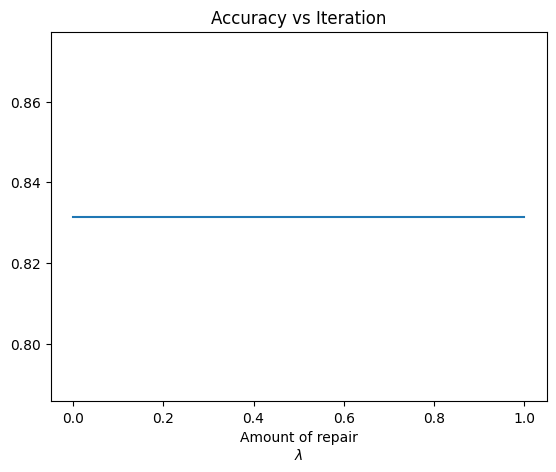

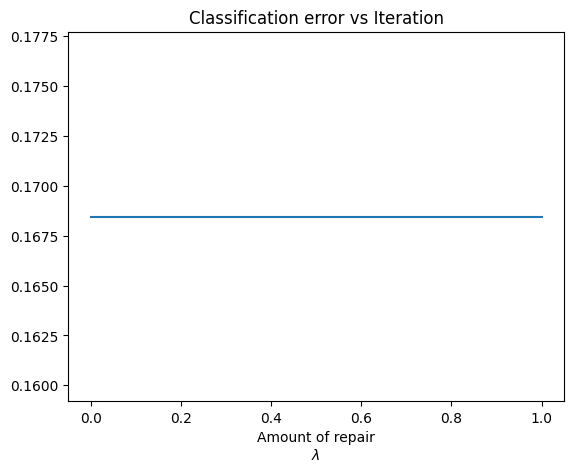

In [10]:
#plot accuracy 
alpha = np.linspace(0,1,iter)
plt.plot(alpha, accuracys)
plt.xlabel('Iteration')
plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.title('Accuracy vs Iteration')
plt.show()

#plot classification error
plt.plot(alpha, Classificatoin_error)
plt.xlabel('Iteration')
plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.title('Classification error vs Iteration')
plt.show()


<Figure size 1000x800 with 0 Axes>

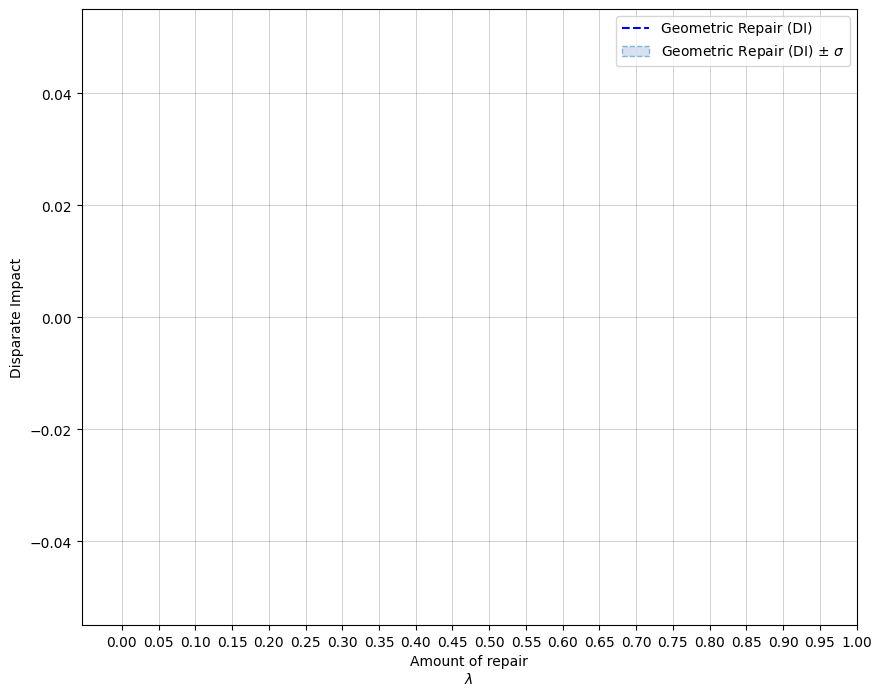

In [11]:
#---format the repaired dataset
fig = plt.figure(figsize=(10, 8))


alpha = np.linspace(0,1,iter)


fig = plt.figure(figsize=(10, 8))
plt.plot(alpha,DI_geometric[:,1], label = 'Geometric Repair (DI)', color = 'blue', linestyle = 'dashed')
plt.fill_between(alpha, DI_geometric[:,2], DI_geometric[:,0], alpha=0.5, edgecolor=blue1, facecolor=blue2, linewidth=1, antialiased=True, linestyle = 'dashed', label=r'Geometric Repair (DI) ± $\sigma$')


plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.ylabel('Disparate Impact')
plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)
plt.show()